# Machine Learning Models Implementation

This notebook implements several ML models based on the EDA and PCA results. The top 14 features identified after PCA are used for modeling. The workflow includes:

- Data loading and preprocessing (scaling, one-hot encoding)
- Train/validation/test split (80/10/10)
- Model training and hyperparameter tuning using Optuna
- Models: Logistic Regression (Ridge & Lasso), Naive Bayes, Random Forest, SVM, Decision Tree

**Top 14 Features:**
1. RiskScore
2. MonthlyCharges
3. AvgChargesPerMonth
4. ContractRisk
5. Contract
6. TotalServices
7. TotalCharges
8. EstimatedCLV
9. HasFamily
10. tenure
11. Partner
12. HighValueCustomer
13. PaymentRisk
14. Dependents

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import optuna

# For models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Set constant seed for reproducibility
SEED = 42
np.random.seed(SEED)
# Remove optuna.seed(SEED) as it does not exist
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress all warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('optuna').setLevel(logging.ERROR)
logging.getLogger('xgboost').setLevel(logging.ERROR)
logging.getLogger('lightgbm').setLevel(logging.ERROR)

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%pip install optuna


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Load dataset and select top 14 features
features = ['RiskScore', 'MonthlyCharges', 'EstimatedCLV', 'tenure', 'ContractRisk', 'PaymentRisk', 'PhoneService', 'AvgChargesPerMonth', 'TechSupport', 'OnlineSecurity', 'TotalCharges', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']

df = pd.read_csv('final_telco_engineered.csv')
X = df[features]
# Assuming target column is 'Churn' (update if different)
y = df['Churn']

In [4]:
# Identify categorical and numerical columns for preprocessing
categorical_cols = ['SeniorCitizen', 'PhoneService', 'TechSupport', 'OnlineSecurity', 'PaperlessBilling', 'PaymentMethod']
numerical_cols = [col for col in features if col not in categorical_cols]

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
])

In [5]:
# Train/validation/test split (80/10/10)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.10, random_state=SEED, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1111, random_state=SEED, stratify=y_temp)
# 0.1111 * 0.90 ≈ 0.10

In [6]:
# Fit preprocessor and transform data
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(X_test)

## Hyperparameter Tuning and Model Training

The following cells use Optuna for hyperparameter optimization for each model. The best model from validation is then evaluated on the test set.

In [7]:
# Metrics helper: accuracy, precision, recall, specificity, F1
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def print_metrics(y_true, y_pred, pos_label):
    labels = np.unique(y_true)
    if pos_label not in labels:
        raise ValueError("pos_label not found in y_true labels.")
    # Determine negative label (binary case expected)
    neg_candidates = [l for l in labels if l != pos_label]
    specificity = float('nan')
    if len(neg_candidates) == 1:
        neg_label = neg_candidates[0]
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[neg_label, pos_label]).ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, pos_label=pos_label, zero_division=0)
    rec = recall_score(y_true, y_pred, pos_label=pos_label, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=pos_label, zero_division=0)
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | Specificity: {specificity:.4f} | F1: {f1:.4f}")

Trial 0: penalty=l2, C=0.8471801418819978, f1=0.6390
Trial 1: penalty=l1, C=0.004207053950287938, f1=0.6082
Trial 2: penalty=l2, C=0.2537815508265665, f1=0.6403
Trial 3: penalty=l1, C=7.579479953348009, f1=0.6417
Trial 4: penalty=l1, C=0.005337032762603957, f1=0.6063
Trial 5: penalty=l2, C=0.12561043700013558, f1=0.6417
Trial 6: penalty=l1, C=0.2801635158716261, f1=0.6415
Trial 7: penalty=l2, C=0.029204338471814112, f1=0.6445
Trial 8: penalty=l2, C=0.006290644294586149, f1=0.6362
Trial 9: penalty=l2, C=0.0015339162591163618, f1=0.6303
Trial 10: penalty=l2, C=0.028504320627871477, f1=0.6445
Trial 11: penalty=l2, C=0.024400771927662247, f1=0.6418
Trial 12: penalty=l2, C=0.029395928467280456, f1=0.6445
Trial 13: penalty=l2, C=0.027727743529257214, f1=0.6418
Trial 14: penalty=l2, C=0.055504515231714534, f1=0.6445
Trial 15: penalty=l2, C=1.267282638458976, f1=0.6403
Trial 16: penalty=l2, C=0.010644290033697096, f1=0.6320
Trial 17: penalty=l2, C=0.0015648063586226114, f1=0.6303
Trial 18: pen

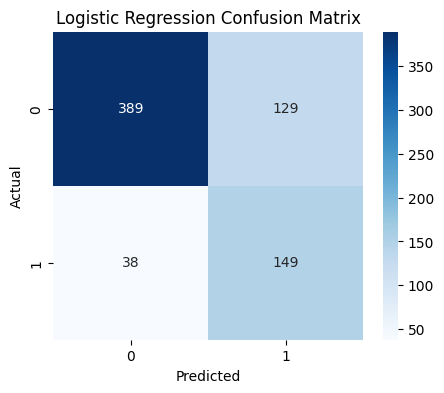

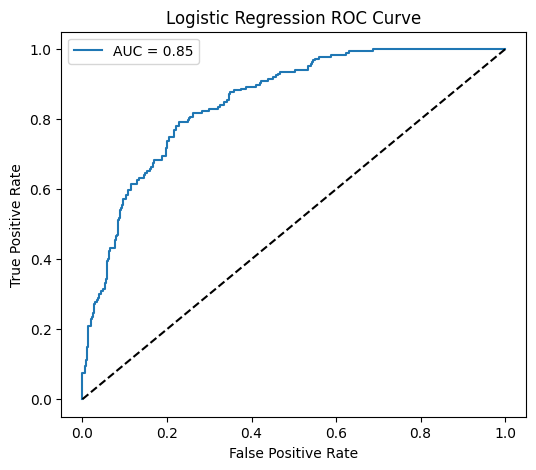

In [8]:
# Logistic Regression (Ridge & Lasso) with Optuna and single validation split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

def objective_logreg(trial):
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_float('C', 1e-3, 10.0, log=True)
    solver = 'liblinear' if penalty == 'l1' else 'lbfgs'
    clf = LogisticRegression(penalty=penalty, C=C, solver=solver, max_iter=1000, random_state=SEED, class_weight=class_weight_dict)
    clf.fit(X_train_proc, y_train)
    y_pred = clf.predict(X_val_proc)
    score = f1_score(y_val, y_pred, pos_label='Yes', zero_division=0)
    print(f'Trial {trial.number}: penalty={penalty}, C={C}, f1={score:.4f}')
    return score

optuna.logging.set_verbosity(optuna.logging.WARNING)
study_logreg = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_logreg.optimize(objective_logreg, n_trials=50)

print('\n=== Logistic Regression Best Hyperparameters ===')
print(f'Best trial: {study_logreg.best_trial.number}')
print(f'Best F1 score: {study_logreg.best_value:.4f}')
print(f'Best params: {study_logreg.best_params}')

best_params_logreg = study_logreg.best_params
best_logreg = LogisticRegression(**best_params_logreg, solver='liblinear' if best_params_logreg['penalty']=='l1' else 'lbfgs', max_iter=1000, random_state=SEED, class_weight=class_weight_dict)
best_logreg.fit(X_train_proc, y_train)
y_test_pred_logreg = best_logreg.predict(X_test_proc)
y_test_proba_logreg = best_logreg.predict_proba(X_test_proc)[:, 1]

print('Logistic Regression Test Metrics:')
print_metrics(y_test, y_test_pred_logreg, pos_label='Yes')

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_logreg)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_test_proba_logreg, pos_label='Yes')
auc = roc_auc_score(y_test, y_test_proba_logreg)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend()
plt.show()

In [9]:
# Logistic Regression: Top 5 Features based on coefficients
# Get feature names after preprocessing
feature_names = []
# Numerical features (scaled)
feature_names.extend(numerical_cols)
# Categorical features (one-hot encoded, first category dropped)
for col in categorical_cols:
    unique_vals = df[col].unique()
    # OneHotEncoder drops first category, so we get n-1 features
    for val in sorted(unique_vals)[1:]:
        feature_names.append(f"{col}_{val}")

# Get coefficients
coefficients = best_logreg.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

print("\n=== Logistic Regression: Top 5 Most Important Features ===")
print(feature_importance.head(5).to_string(index=False))
print("\nNote: Features with larger absolute coefficients have stronger influence on predictions.")


=== Logistic Regression: Top 5 Most Important Features ===
         Feature  Coefficient  Abs_Coefficient
       RiskScore     0.863196         0.863196
PhoneService_Yes    -0.634149         0.634149
  MonthlyCharges     0.503673         0.503673
          tenure    -0.475396         0.475396
 TechSupport_Yes    -0.442074         0.442074

Note: Features with larger absolute coefficients have stronger influence on predictions.


Trial 0: var_smoothing=3.148911647956852e-10, f1=0.6245
Trial 1: var_smoothing=6.351221010640693e-08, f1=0.6245
Trial 2: var_smoothing=8.47180141881997e-09, f1=0.6245
Trial 3: var_smoothing=2.481040974867806e-09, f1=0.6245
Trial 4: var_smoothing=4.2079886696066266e-11, f1=0.6245
Trial 5: var_smoothing=4.2070539502879275e-11, f1=0.6245
Trial 6: var_smoothing=1.707396743152808e-11, f1=0.6245
Trial 7: var_smoothing=2.9154431891537547e-08, f1=0.6245
Trial 8: var_smoothing=2.5378155082656586e-09, f1=0.6245
Trial 9: var_smoothing=6.796578090758142e-09, f1=0.6245
Trial 10: var_smoothing=3.147070849889824e-10, f1=0.6245
Trial 11: var_smoothing=3.6313970346434915e-10, f1=0.6245
Trial 12: var_smoothing=7.553503645583179e-08, f1=0.6245
Trial 13: var_smoothing=2.4400771927662207e-10, f1=0.6245
Trial 14: var_smoothing=9.714866589957516e-10, f1=0.6245
Trial 15: var_smoothing=2.7531913049290154e-08, f1=0.6245
Trial 16: var_smoothing=1.0514141925502058e-10, f1=0.6245
Trial 17: var_smoothing=1.12720480

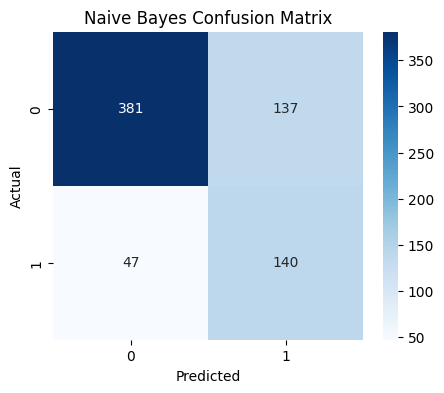

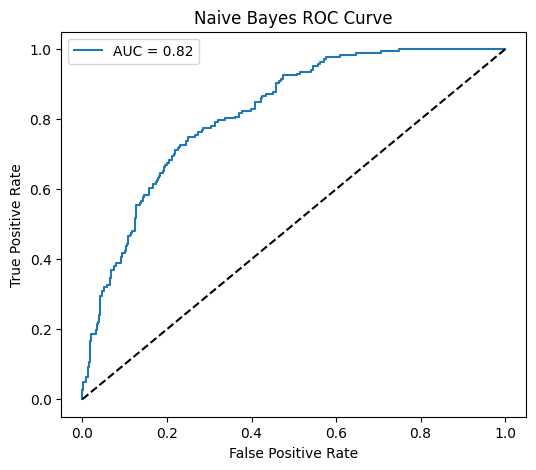

In [10]:
# Naive Bayes with Optuna (GaussianNB) and single validation split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

def objective_nb(trial):
    var_smoothing = trial.suggest_float('var_smoothing', 1e-11, 1e-7, log=True)
    clf = GaussianNB(var_smoothing=var_smoothing)
    clf.fit(X_train_proc, y_train)
    y_pred = clf.predict(X_val_proc)
    score = f1_score(y_val, y_pred, pos_label='Yes', zero_division=0)
    print(f'Trial {trial.number}: var_smoothing={var_smoothing}, f1={score:.4f}')
    return score

study_nb = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_nb.optimize(objective_nb, n_trials=50)

print('\n=== Naive Bayes Best Hyperparameters ===')
print(f'Best trial: {study_nb.best_trial.number}')
print(f'Best F1 score: {study_nb.best_value:.4f}')
print(f'Best params: {study_nb.best_params}')

best_params_nb = study_nb.best_params
best_nb = GaussianNB(**best_params_nb)
best_nb.fit(X_train_proc, y_train)
y_test_pred_nb = best_nb.predict(X_test_proc)
y_test_proba_nb = best_nb.predict_proba(X_test_proc)[:, 1]

print('Naive Bayes Test Metrics:')
print_metrics(y_test, y_test_pred_nb, pos_label='Yes')

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_nb)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_test_proba_nb, pos_label='Yes')
auc = roc_auc_score(y_test, y_test_proba_nb)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes ROC Curve')
plt.legend()
plt.show()

Trial 0: n_estimators=144, max_depth=20, min_samples_split=8, min_samples_leaf=6, f1=0.6364
Trial 1: n_estimators=89, max_depth=4, min_samples_split=2, min_samples_leaf=9, f1=0.6390
Trial 2: n_estimators=200, max_depth=15, min_samples_split=2, min_samples_leaf=10, f1=0.6438
Trial 3: n_estimators=258, max_depth=6, min_samples_split=3, min_samples_leaf=2, f1=0.6261
Trial 4: n_estimators=126, max_depth=11, min_samples_split=5, min_samples_leaf=3, f1=0.6392
Trial 5: n_estimators=203, max_depth=4, min_samples_split=4, min_samples_leaf=4, f1=0.6282
Trial 6: n_estimators=164, max_depth=16, min_samples_split=3, min_samples_leaf=6, f1=0.6366
Trial 7: n_estimators=198, max_depth=2, min_samples_split=7, min_samples_leaf=2, f1=0.6184
Trial 8: n_estimators=66, max_depth=20, min_samples_split=10, min_samples_leaf=9, f1=0.6483
Trial 9: n_estimators=126, max_depth=3, min_samples_split=8, min_samples_leaf=5, f1=0.6167
Trial 10: n_estimators=55, max_depth=19, min_samples_split=10, min_samples_leaf=8, f1

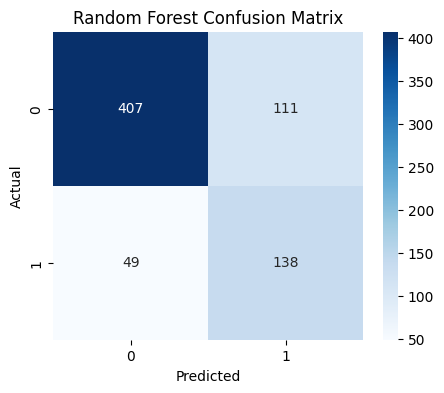

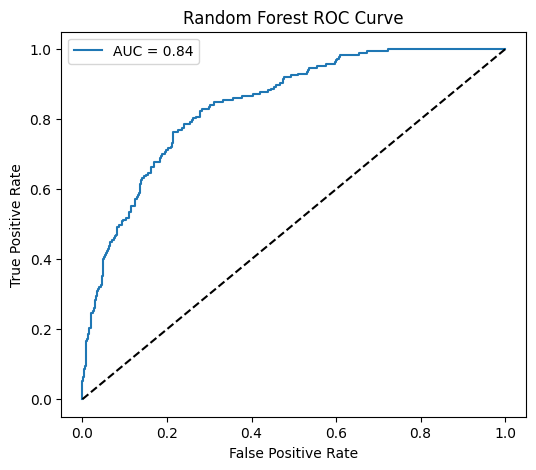

In [11]:
# Random Forest with Optuna and single validation split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=SEED,
        class_weight=class_weight_dict
    )
    clf.fit(X_train_proc, y_train)
    y_pred = clf.predict(X_val_proc)
    score = f1_score(y_val, y_pred, pos_label='Yes', zero_division=0)
    print(f'Trial {trial.number}: n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, f1={score:.4f}')
    return score

study_rf = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_rf.optimize(objective_rf, n_trials=50)

print('\n=== Random Forest Best Hyperparameters ===')
print(f'Best trial: {study_rf.best_trial.number}')
print(f'Best F1 score: {study_rf.best_value:.4f}')
print(f'Best params: {study_rf.best_params}')

best_params_rf = study_rf.best_params
best_rf = RandomForestClassifier(**best_params_rf, random_state=SEED, class_weight=class_weight_dict)
best_rf.fit(X_train_proc, y_train)
y_test_pred_rf = best_rf.predict(X_test_proc)
y_test_proba_rf = best_rf.predict_proba(X_test_proc)[:, 1]

print('Random Forest Test Metrics:')
print_metrics(y_test, y_test_pred_rf, pos_label='Yes')

print('Random Forest Test Accuracy:', accuracy_score(y_test, y_test_pred_rf))
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_test_proba_rf, pos_label='Yes')
auc = roc_auc_score(y_test, y_test_proba_rf)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend()
plt.show()


=== Random Forest: Top 5 Most Important Features ===
           Feature  Importance
      ContractRisk    0.186028
         RiskScore    0.158798
            tenure    0.104569
    MonthlyCharges    0.097986
AvgChargesPerMonth    0.086288


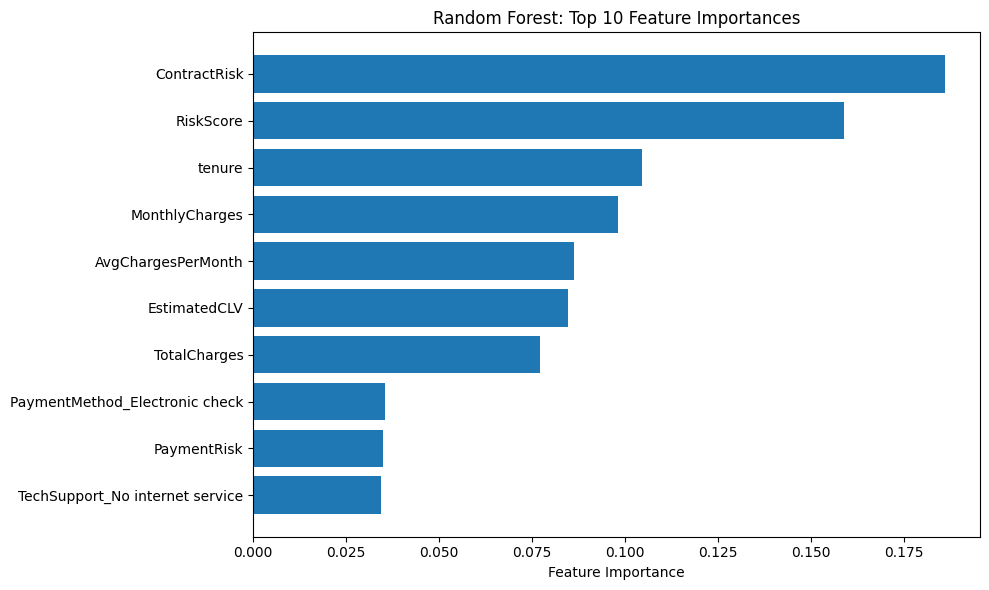


Note: Feature importance is calculated as the mean decrease in impurity (Gini importance).


In [12]:
# Random Forest: Top 5 Features based on importance
rf_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n=== Random Forest: Top 5 Most Important Features ===")
print(rf_feature_importance.head(5).to_string(index=False))

# Visualize feature importances
plt.figure(figsize=(10, 6))
top_10_features = rf_feature_importance.head(10)
plt.barh(range(len(top_10_features)), top_10_features['Importance'])
plt.yticks(range(len(top_10_features)), top_10_features['Feature'])
plt.xlabel('Feature Importance')
plt.title('Random Forest: Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nNote: Feature importance is calculated as the mean decrease in impurity (Gini importance).")

Trial 0: C=0.0746, kernel=linear, gamma=0.0003, f1=0.6324
Trial 1: C=0.0060, kernel=rbf, gamma=0.0133, f1=0.5992
Trial 2: C=0.0013, kernel=linear, gamma=0.0004, f1=0.6272
Trial 3: C=0.0083, kernel=rbf, gamma=0.0007, f1=0.0000
Trial 4: C=1.1462, kernel=poly, gamma=0.0023, f1=0.0000
Trial 5: C=8.4310, kernel=poly, gamma=0.0001, f1=0.4193
Trial 6: C=1.0907, kernel=poly, gamma=0.0789, f1=0.6280
Trial 7: C=11.0151, kernel=poly, gamma=0.0021, f1=0.0000
Trial 8: C=0.0041, kernel=poly, gamma=0.0006, f1=0.0000
Trial 9: C=2.0541, kernel=poly, gamma=0.0004, f1=0.0000
Trial 10: C=0.0745, kernel=linear, gamma=0.0001, f1=0.6324
Trial 11: C=0.0542, kernel=linear, gamma=0.0001, f1=0.6324
Trial 12: C=0.1155, kernel=linear, gamma=0.0001, f1=0.6312
Trial 13: C=0.0753, kernel=linear, gamma=0.0071, f1=0.6312
Trial 14: C=0.0269, kernel=linear, gamma=0.0011, f1=0.6312
Trial 15: C=0.2240, kernel=linear, gamma=0.0003, f1=0.6312
Trial 16: C=0.4604, kernel=linear, gamma=0.0091, f1=0.6233
Trial 17: C=75.6168, ker

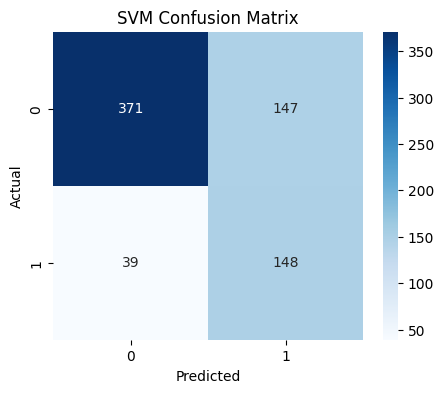

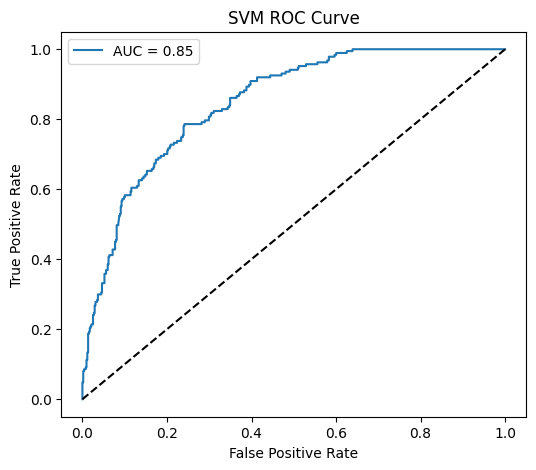

In [13]:
# SVM with Optuna and single validation split, with timeout for each trial
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import optuna
import threading
import warnings
warnings.filterwarnings('ignore')
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

# Timeout wrapper for objective function
class TrialTimeout(Exception):
    pass

def run_with_timeout(func, args=(), kwargs=None, timeout=60):
    result = {}
    def target():
        try:
            result['value'] = func(*args, **(kwargs or {}))
        except Exception as e:
            result['error'] = e
    thread = threading.Thread(target=target)
    thread.start()
    thread.join(timeout)
    if thread.is_alive():
        raise TrialTimeout('Trial exceeded timeout')
    if 'error' in result:
        raise result['error']
    return result.get('value')

def objective_svm(trial):
    def inner_objective():
        C = trial.suggest_float('C', 1e-3, 1e2, log=True)
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
        gamma = trial.suggest_float('gamma', 1e-4, 1e-1, log=True)
        clf = SVC(C=C, kernel=kernel, gamma=gamma, probability=True, random_state=SEED, class_weight=class_weight_dict)
        clf.fit(X_train_proc, y_train)
        y_pred = clf.predict(X_val_proc)
        score = f1_score(y_val, y_pred, pos_label='Yes', zero_division=0)
        print(f'Trial {trial.number}: C={C:.4f}, kernel={kernel}, gamma={gamma:.4f}, f1={score:.4f}')
        return score
    try:
        return run_with_timeout(inner_objective, timeout=30)  # 30 seconds per trial
    except TrialTimeout:
        print(f'Trial {trial.number} timed out.')
        return 0.0  # Return poor score if timeout

study_svm = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_svm.optimize(objective_svm, n_trials=50)

print('\n=== SVM Best Hyperparameters ===')
print(f'Best trial: {study_svm.best_trial.number}')
print(f'Best F1 score: {study_svm.best_value:.4f}')
print(f'Best params: {study_svm.best_params}')

best_params_svm = study_svm.best_params
best_svm = SVC(**best_params_svm, probability=True, random_state=SEED, class_weight=class_weight_dict)
best_svm.fit(X_train_proc, y_train)
y_test_pred_svm = best_svm.predict(X_test_proc)
y_test_proba_svm = best_svm.predict_proba(X_test_proc)[:, 1]

print('SVM Test Metrics:')
print_metrics(y_test, y_test_pred_svm, pos_label='Yes')

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_svm)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_test_proba_svm, pos_label='Yes')
auc = roc_auc_score(y_test, y_test_proba_svm)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve')
plt.legend()
plt.show()

Trial 0: max_depth=9, min_samples_split=10, min_samples_leaf=8, f1=0.5992
Trial 1: max_depth=13, min_samples_split=3, min_samples_leaf=2, f1=0.5747
Trial 2: max_depth=3, min_samples_split=9, min_samples_leaf=7, f1=0.6108
Trial 3: max_depth=15, min_samples_split=2, min_samples_leaf=10, f1=0.5556
Trial 4: max_depth=17, min_samples_split=3, min_samples_leaf=2, f1=0.5585
Trial 5: max_depth=5, min_samples_split=4, min_samples_leaf=6, f1=0.6191
Trial 6: max_depth=10, min_samples_split=4, min_samples_leaf=7, f1=0.5813
Trial 7: max_depth=4, min_samples_split=4, min_samples_leaf=4, f1=0.6108
Trial 8: max_depth=10, min_samples_split=9, min_samples_leaf=2, f1=0.5979
Trial 9: max_depth=11, min_samples_split=7, min_samples_leaf=1, f1=0.5819
Trial 10: max_depth=7, min_samples_split=6, min_samples_leaf=5, f1=0.6167
Trial 11: max_depth=6, min_samples_split=6, min_samples_leaf=5, f1=0.6112
Trial 12: max_depth=6, min_samples_split=6, min_samples_leaf=4, f1=0.6167
Trial 13: max_depth=20, min_samples_spli

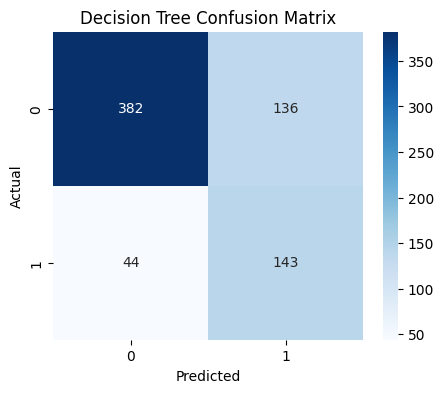

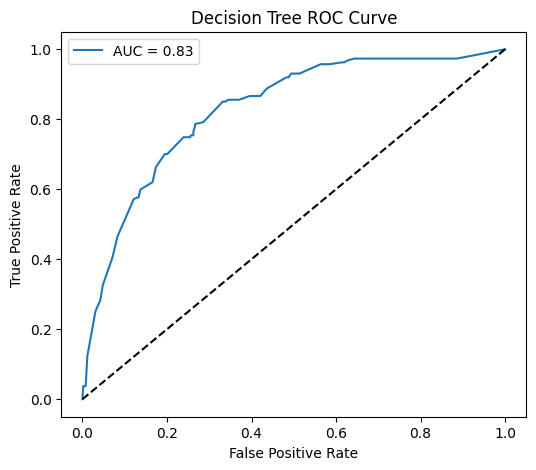

In [14]:
# Decision Tree with Optuna and single validation split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

def objective_dt(trial):
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    clf = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=SEED,
        class_weight=class_weight_dict
    )
    clf.fit(X_train_proc, y_train)
    y_pred = clf.predict(X_val_proc)
    score = f1_score(y_val, y_pred, pos_label='Yes', zero_division=0)
    print(f'Trial {trial.number}: max_depth={max_depth}, min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, f1={score:.4f}')
    return score

study_dt = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_dt.optimize(objective_dt, n_trials=50)

print('\n=== Decision Tree Best Hyperparameters ===')
print(f'Best trial: {study_dt.best_trial.number}')
print(f'Best F1 score: {study_dt.best_value:.4f}')
print(f'Best params: {study_dt.best_params}')

best_params_dt = study_dt.best_params
best_dt = DecisionTreeClassifier(**best_params_dt, random_state=SEED, class_weight=class_weight_dict)
best_dt.fit(X_train_proc, y_train)
y_test_pred_dt = best_dt.predict(X_test_proc)
y_test_proba_dt = best_dt.predict_proba(X_test_proc)[:, 1]

print('Decision Tree Test Metrics:')
print_metrics(y_test, y_test_pred_dt, pos_label='Yes')

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_dt)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_test_proba_dt, pos_label='Yes')
auc = roc_auc_score(y_test, y_test_proba_dt)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.legend()
plt.show()


=== Decision Tree: Top 5 Most Important Features ===
           Feature  Importance
      ContractRisk    0.545307
    MonthlyCharges    0.124768
            tenure    0.110555
AvgChargesPerMonth    0.060544
      TotalCharges    0.041638


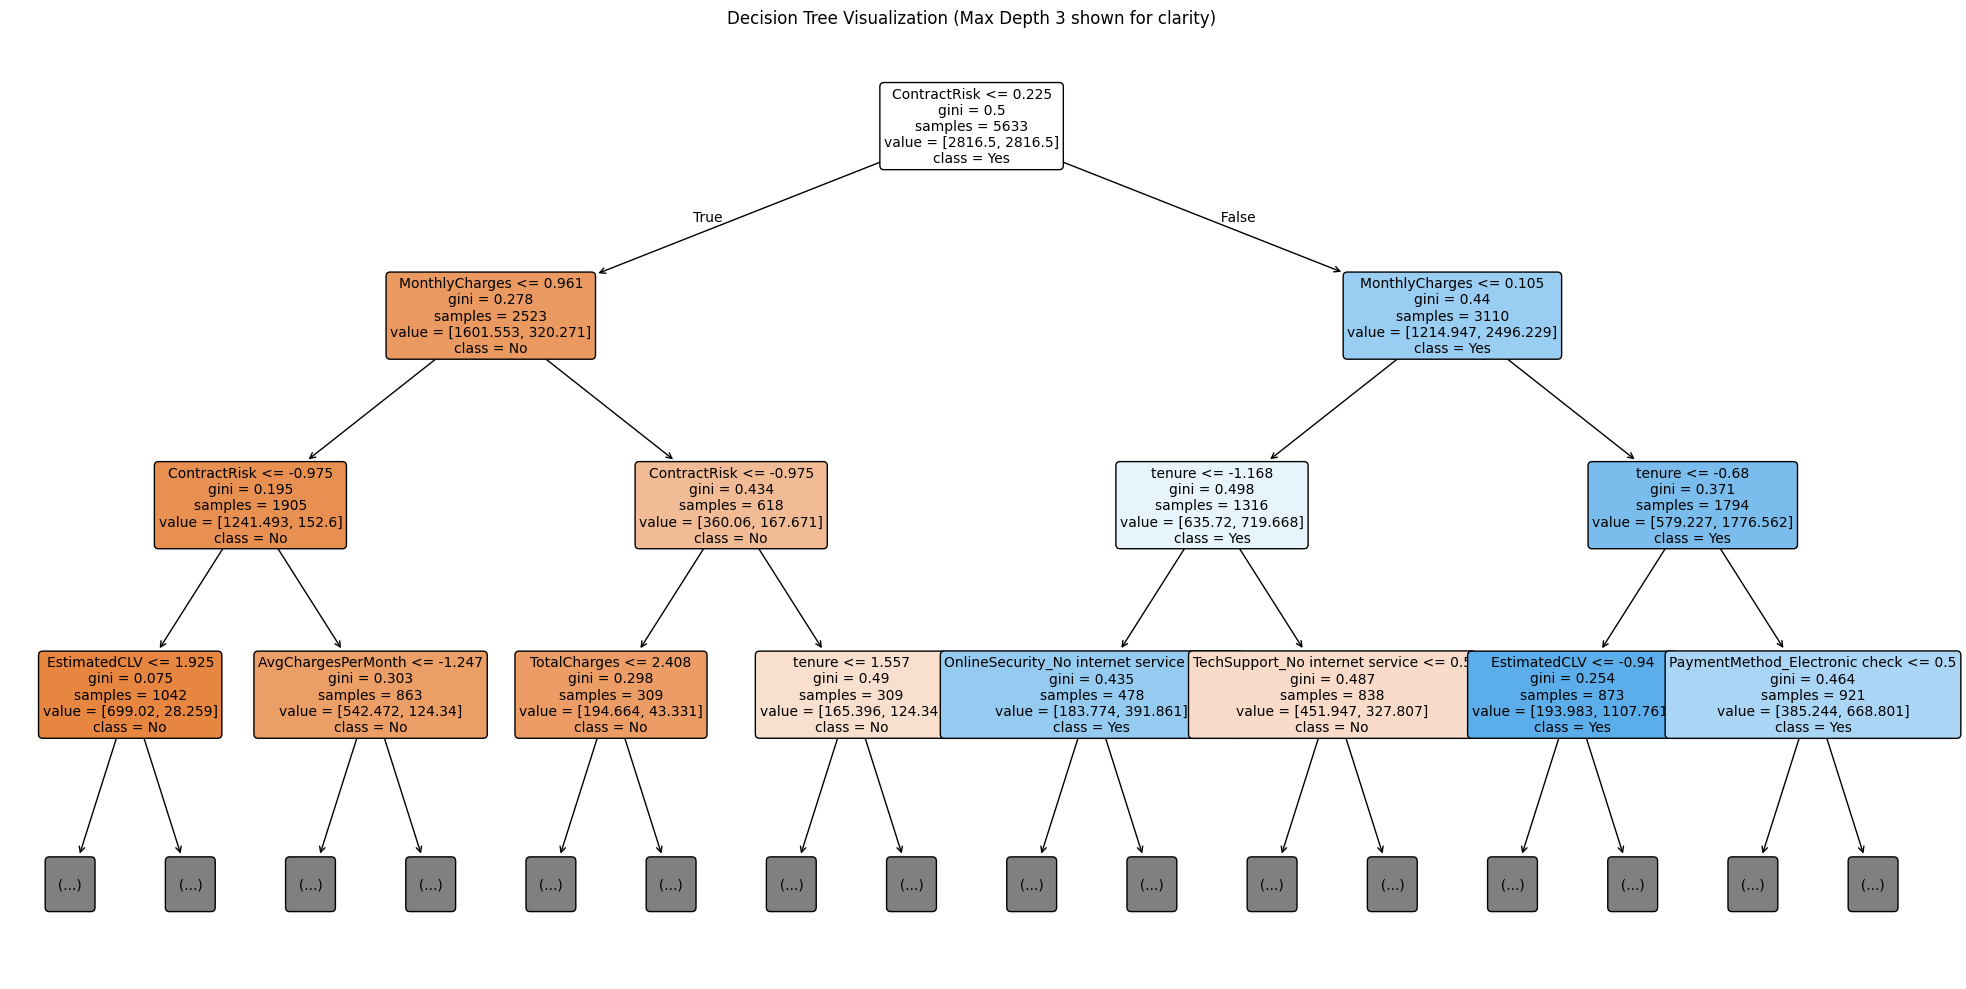


Note: The tree visualization shows the decision path. Each node shows:
  - The decision rule (feature threshold)
  - Gini impurity
  - Number of samples
  - Class distribution [No, Yes]
  - Predicted class (color coded)


In [15]:
# Decision Tree: Top 5 Features and Decision Path Visualization
from sklearn.tree import plot_tree

# Get feature importances
dt_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_dt.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n=== Decision Tree: Top 5 Most Important Features ===")
print(dt_feature_importance.head(5).to_string(index=False))

# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(best_dt, 
          feature_names=feature_names,
          class_names=['No', 'Yes'],
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=3)  # Limit depth for readability
plt.title('Decision Tree Visualization (Max Depth 3 shown for clarity)')
plt.tight_layout()
plt.show()

print("\nNote: The tree visualization shows the decision path. Each node shows:")
print("  - The decision rule (feature threshold)")
print("  - Gini impurity")
print("  - Number of samples")
print("  - Class distribution [No, Yes]")
print("  - Predicted class (color coded)")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Trial 0: n_estimators=144, max_depth=10, learning_rate=0.222, f1=0.5543
Trial 1: n_estimators=89, max_depth=2, learning_rate=0.261, f1=0.6444
Trial 2: n_estimators=55, max_depth=10, learning_rate=0.251, f1=0.5570
Trial 3: n_estimators=96, max_depth=4, learning_rate=0.162, f1=0.6195
Trial 4: n_estimators=203, max_depth=3, learning_rate=0.095, f1=0.6377
Trial 5: n_estimators=247, max_depth=3, learning_rate=0.159, f1=0.6232
Trial 6: n_estimators=202, max_depth=3, learning_rate=0.029, f1=0.6427
Trial 7: n_estimators=252, max_depth=4, learning_rate=0.038, f1=0.6265
Trial 8: n_estimators=80, max_depth=6, learning_rate=0.020, f1=0.6329
Trial 9: n_estimators=216, max_depth=4, learning_rate=0.161, f1=0.6020
Trial 10: n_estimators=139, max_depth=7, learning_rate=0.291, f1=0.5722
Trial 11: n_estimators=159, max_depth=2, lear

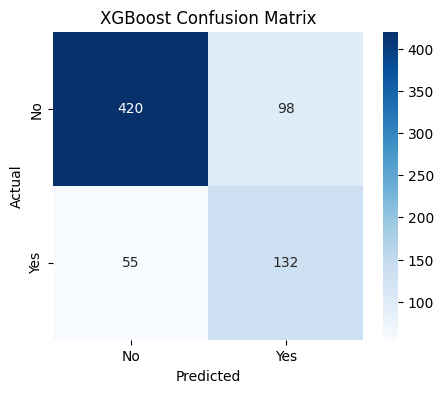

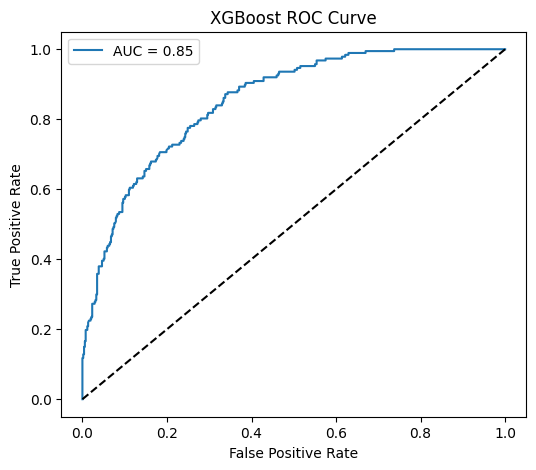

In [16]:
# XGBoost, LightGBM, and KNN with Optuna, validation split, class weights, and plots
# Install required packages if not already installed
%pip install xgboost lightgbm

# Encode target for XGBoost and LightGBM
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

# Compute encoded label for 'Yes' to use as pos_label in F1
yes_label = le.transform(['Yes'])[0]

# XGBoost
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

scale_pos_weight = class_weight_dict.get('Yes', 1) if 'Yes' in class_weight_dict else 1

def objective_xgb(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    clf = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=SEED,
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight
    )
    clf.fit(X_train_proc, y_train_enc)
    y_pred = clf.predict(X_val_proc)
    score = f1_score(y_val_enc, y_pred, pos_label=yes_label, zero_division=0)
    print(f'Trial {trial.number}: n_estimators={n_estimators}, max_depth={max_depth}, learning_rate={learning_rate:.3f}, f1={score:.4f}')
    return score

study_xgb = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_xgb.optimize(objective_xgb, n_trials=50)

print('\n=== XGBoost Best Hyperparameters ===')
print(f'Best trial: {study_xgb.best_trial.number}')
print(f'Best F1 score: {study_xgb.best_value:.4f}')
print(f'Best params: {study_xgb.best_params}')

best_params_xgb = study_xgb.best_params
best_xgb = XGBClassifier(**best_params_xgb, random_state=SEED, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight)
best_xgb.fit(X_train_proc, y_train_enc)
y_test_pred_xgb = best_xgb.predict(X_test_proc)
y_test_proba_xgb = best_xgb.predict_proba(X_test_proc)[:, 1]

print('XGBoost Test Metrics:')
yes_label = le.transform(['Yes'])[0]
print_metrics(y_test_enc, y_test_pred_xgb, pos_label=yes_label)

cm = confusion_matrix(y_test_enc, y_test_pred_xgb)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
fpr, tpr, _ = roc_curve(y_test_enc, y_test_proba_xgb, pos_label=yes_label)
auc = roc_auc_score(y_test_enc, y_test_proba_xgb)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend()
plt.show()

In [17]:
# XGBoost: Top 5 Features based on Gain
import pandas as pd

# get_score returns dict like {'f0': gain0, 'f1': gain1, ...}
gain_scores = best_xgb.get_booster().get_score(importance_type='gain')

# Map f-index keys to feature_names created earlier
mapped = []
for k, v in gain_scores.items():
    try:
        idx = int(k[1:])  # strip 'f'
        fname = feature_names[idx] if idx < len(feature_names) else k
    except Exception:
        fname = k
    mapped.append((fname, v))

xgb_gain_df = pd.DataFrame(mapped, columns=['Feature', 'Gain']).sort_values('Gain', ascending=False)
print("\n=== XGBoost: Top 5 Features by Gain ===")
print(xgb_gain_df.head(5).to_string(index=False))


=== XGBoost: Top 5 Features by Gain ===
                        Feature       Gain
                   ContractRisk 135.984497
TechSupport_No internet service  62.441887
                      RiskScore  59.020000
           PaperlessBilling_Yes  20.050652
                         tenure  17.122898


[LightGBM] [Info] Number of positive: 1495, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 5633, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

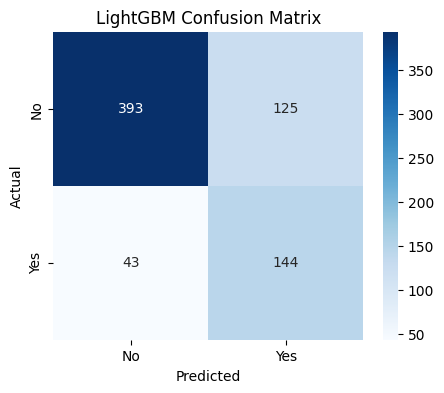

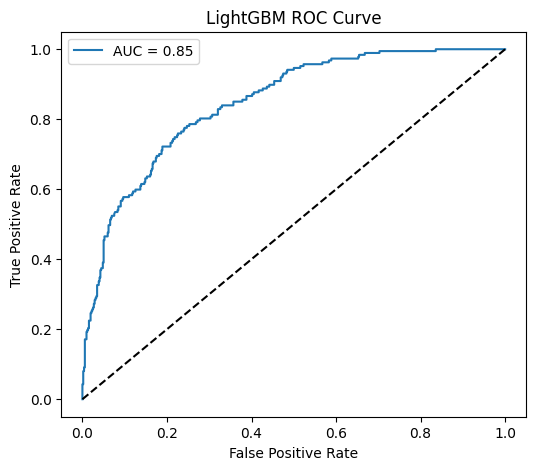

In [18]:
# LightGBM (with encoded labels and encoded class weights)
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

# Use the same label encoder as XGBoost cell (already defined above)
# y_train_enc, y_val_enc, y_test_enc already exist

# Compute class weights for encoded labels
classes_enc = np.unique(y_train_enc)
class_weights_enc = compute_class_weight('balanced', classes=classes_enc, y=y_train_enc)
class_weight_dict_enc = dict(zip(classes_enc, class_weights_enc))

def objective_lgbm(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    num_leaves = trial.suggest_int('num_leaves', 10, 100)
    clf = LGBMClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        random_state=SEED,
        class_weight=class_weight_dict_enc
    )
    clf.fit(X_train_proc, y_train_enc)
    y_pred = clf.predict(X_val_proc)
    score = f1_score(y_val_enc, y_pred, pos_label=yes_label, zero_division=0)
    print(f'Trial {trial.number}: n_estimators={n_estimators}, max_depth={max_depth}, learning_rate={learning_rate:.3f}, num_leaves={num_leaves}, f1={score:.4f}')
    return score

study_lgbm = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_lgbm.optimize(objective_lgbm, n_trials=50)

print('\n=== LightGBM Best Hyperparameters ===')
print(f'Best trial: {study_lgbm.best_trial.number}')
print(f'Best F1 score: {study_lgbm.best_value:.4f}')
print(f'Best params: {study_lgbm.best_params}')

best_params_lgbm = study_lgbm.best_params
best_lgbm = LGBMClassifier(**best_params_lgbm, random_state=SEED, class_weight=class_weight_dict_enc)
best_lgbm.fit(X_train_proc, y_train_enc)
y_test_pred_lgbm = best_lgbm.predict(X_test_proc)
y_test_proba_lgbm = best_lgbm.predict_proba(X_test_proc)[:, 1]

print('LightGBM Test Metrics:')
yes_label = le.transform(['Yes'])[0]
print_metrics(y_test_enc, y_test_pred_lgbm, pos_label=yes_label)

cm = confusion_matrix(y_test_enc, y_test_pred_lgbm)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('LightGBM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
fpr, tpr, _ = roc_curve(y_test_enc, y_test_proba_lgbm, pos_label=yes_label)
auc = roc_auc_score(y_test_enc, y_test_proba_lgbm)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LightGBM ROC Curve')
plt.legend()
plt.show()

In [19]:
# LightGBM: Top 5 Features based on Gain
import pandas as pd

# Use booster to access gain importances
booster = best_lgbm.booster_
lgb_gain = booster.feature_importance(importance_type='gain')

# Map LightGBM's generic column names to actual feature names
# feature_names was created earlier when we built the feature list for the preprocessor
lgb_gain_df = pd.DataFrame({
    'Feature': feature_names,  # Use our pre-defined feature_names list
    'Gain': lgb_gain
}).sort_values('Gain', ascending=False)

print("\n=== LightGBM: Top 5 Features by Gain ===")
print(lgb_gain_df.head(5).to_string(index=False))


=== LightGBM: Top 5 Features by Gain ===
           Feature         Gain
      ContractRisk 12404.443794
    MonthlyCharges  3976.054073
            tenure  3457.019089
AvgChargesPerMonth  2861.719433
      TotalCharges  1867.795664


Trial 0: n_neighbors=13, weights=uniform, p=2, f1=0.5405
Trial 1: n_neighbors=7, weights=uniform, p=2, f1=0.5775
Trial 2: n_neighbors=19, weights=uniform, p=2, f1=0.5421
Trial 3: n_neighbors=26, weights=uniform, p=1, f1=0.5500
Trial 4: n_neighbors=11, weights=uniform, p=1, f1=0.5366
Trial 5: n_neighbors=20, weights=distance, p=1, f1=0.5619
Trial 6: n_neighbors=15, weights=uniform, p=2, f1=0.5465
Trial 7: n_neighbors=19, weights=distance, p=1, f1=0.5858
Trial 8: n_neighbors=4, weights=distance, p=2, f1=0.5480
Trial 9: n_neighbors=11, weights=distance, p=1, f1=0.5714
Trial 10: n_neighbors=29, weights=distance, p=1, f1=0.5619
Trial 11: n_neighbors=3, weights=distance, p=2, f1=0.5284
Trial 12: n_neighbors=23, weights=uniform, p=1, f1=0.5471
Trial 13: n_neighbors=7, weights=distance, p=2, f1=0.5723
Trial 14: n_neighbors=17, weights=distance, p=1, f1=0.5697
Trial 15: n_neighbors=8, weights=uniform, p=2, f1=0.5135
Trial 16: n_neighbors=21, weights=uniform, p=2, f1=0.5404
Trial 17: n_neighbors

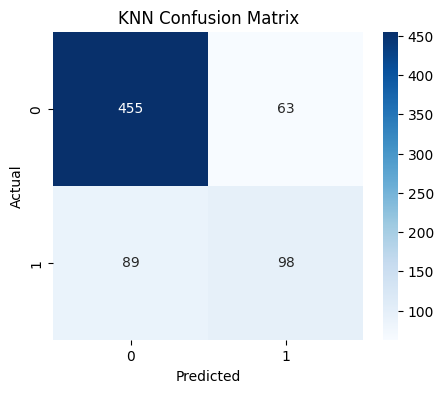

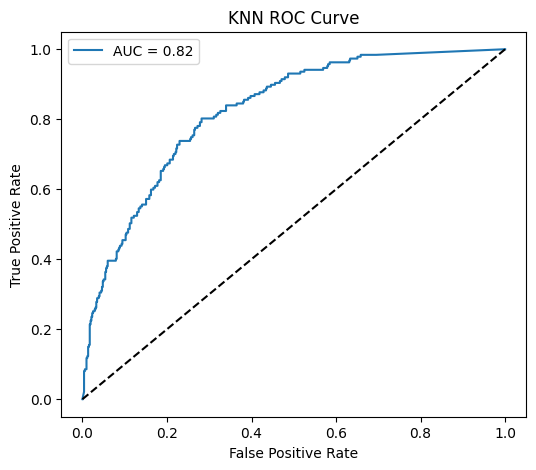

In [22]:
# KNN with label-encoded targets to avoid string/int issues during fitting and scoring
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode target labels once for KNN
le_knn = LabelEncoder()
y_train_enc_knn = le_knn.fit_transform(y_train)
y_val_enc_knn = le_knn.transform(y_val)
y_test_enc_knn = le_knn.transform(y_test)
yes_label_knn = le_knn.transform(['Yes'])[0]


def objective_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 3, 30)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    p = trial.suggest_int('p', 1, 2)
    clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p)
    clf.fit(X_train_proc, y_train_enc_knn)
    y_pred = clf.predict(X_val_proc)
    score = f1_score(y_val_enc_knn, y_pred, pos_label=yes_label_knn, zero_division=0)
    print(f'Trial {trial.number}: n_neighbors={n_neighbors}, weights={weights}, p={p}, f1={score:.4f}')
    return score

study_knn = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_knn.optimize(objective_knn, n_trials=50)

print('\n=== KNN Best Hyperparameters ===')
print(f'Best trial: {study_knn.best_trial.number}')
print(f'Best F1 score: {study_knn.best_value:.4f}')
print(f'Best params: {study_knn.best_params}')

best_params_knn = study_knn.best_params
best_knn = KNeighborsClassifier(**best_params_knn)
best_knn.fit(X_train_proc, y_train_enc_knn)
y_test_pred_knn_enc = best_knn.predict(X_test_proc)
y_test_pred_knn = le_knn.inverse_transform(y_test_pred_knn_enc)

# Probabilities: pick the column corresponding to the encoded 'Yes' class if available
try:
    yes_idx = int(np.where(best_knn.classes_ == yes_label_knn)[0][0])
    y_test_proba_knn = best_knn.predict_proba(X_test_proc)[:, yes_idx]
except Exception:
    y_test_proba_knn = (y_test_pred_knn == 'Yes').astype(int)

print('KNN Test Metrics:')
print_metrics(y_test, y_test_pred_knn, pos_label='Yes')

cm = confusion_matrix(y_test, y_test_pred_knn)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

fpr, tpr, _ = roc_curve(y_test_enc_knn, y_test_proba_knn, pos_label=yes_label_knn)
auc = roc_auc_score(y_test_enc_knn, y_test_proba_knn)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve')
plt.legend()
plt.show()